In [93]:
# Chios
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
train = pd.read_csv('/kaggle/input/newhouseprice/train_processed.csv')
test = pd.read_csv('/kaggle/input/newhouseprice/test_processed.csv')

In [100]:
target_variable = train.resale_price.values
train = train.drop(['resale_price'], axis=1)

In [46]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
scores = {
    'Regressors': ['XGB', 'LightGBM', 'Cat', 'KNN', 'ElasticNet','GBR', 'RF'],
    'Scores': [],
    'Std': []
}
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_variable, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [107]:
xgb = XGBRegressor(
    reg_lambda=0.69,
    max_depth=10,
    reg_alpha=0.95,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_estimators=3000,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.05,
    subsample=0.8,
    tree_method='gpu_hist'
)

xgb_score = cv_rmse(xgb)
scores['Scores'].append(xgb_score.mean())
scores['Std'].append(xgb_score.std())

In [ ]:
lgbmr = LGBMRegressor(
    colsample_bytree=0.8,
    learning_rate=0.05,
    min_child_samples=10,
    num_leaves=12,
    objective='regression',
    n_estimators=4000,
    n_jobs=-1,
    random_state=42,
    subsample=0.7,
    device='gpu'
)

lgb_score = cv_rmse(lgbmr)
scores['Scores'].append(lgb_score.mean())
scores['Std'].append(lgb_score.std())

In [ ]:
cat_model = CatBoostRegressor(loss_function='RMSE', 
                              random_seed=42, 
                              max_depth = 12,
                              learning_rate = 0.05,
                              random_strength=1,
                              max_ctr_complexity=1,
                              l2_leaf_reg=8,
                              grow_policy = 'Lossguide',
                              task_type='GPU',
                              iterations=3000,
                              verbose=0
                              )

cat_score = cv_rmse(lgbmr)
scores['Scores'].append(cat_score.mean())
scores['Std'].append(cat_score.std())

In [7]:
knn = KNeighborsRegressor(n_neighbors=5)
knn_score = cv_rmse(knn)
scores['Scores'].append(knn_score.mean())
scores['Std'].append(knn_score.std())

In [80]:
e_alphas = [0.0001,  0.0003,  0.0005, 0.0007]
e_l1ratio = [0.8, 0.9, 1]
elasticv = ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kf, l1_ratio=e_l1ratio)  
elastic = make_pipeline(RobustScaler(), elasticv)
ela_score = cv_rmse(elastic)
scores['Scores'].append(ela_score.mean())
scores['Std'].append(ela_score.std())

In [ ]:
gb = GradientBoostingRegressor(
    max_depth=10,
    max_features=0.8,
    random_state=42,
    loss='huber',
    subsample=0.7
)

gb_score = cv_rmse(gb)
scores['Scores'].append(gb_score.mean())
scores['Std'].append(gb_score.std())

In [ ]:
rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_score = cv_rmse(rf)
scores['Scores'].append(rf_score.mean())
scores['Std'].append(rf_score.std())

In [113]:
final_scores = pd.DataFrame(scores)
final_scores

,Regressors,Scores,Std
0,XGB,0.054904,0.000249
1,LightGBM,0.057053,0.000232
2,Cat,0.057054,0.000202
3,KNN,0.071036,0.000298
4,ElasticNet,0.184983,0.000347
5,GBR,0.056669,0.000128
6,RF,0.098902,0.000466


In [ ]:
stacked = StackingRegressor(regressors=(gb,
                                          xgb,
                                          lgbmr,
                                          cat_model,
                                          ),
                              meta_regressor = xgb,
                              verbose=1,
                              use_features_in_secondary = True)
stack_score = cv_rmse(stack_gen)

In [ ]:
stacked.fit(train.values, target_variable)

In [ ]:

data = pd.DataFrame({
    'prediction': np.expm1(stacked.predict(train.values)).reshape(1, -1)[0],
    'target': np.expm1(target_variable)
})
sns.scatterplot(x='prediction', y='target', palette='Blues', data=data)

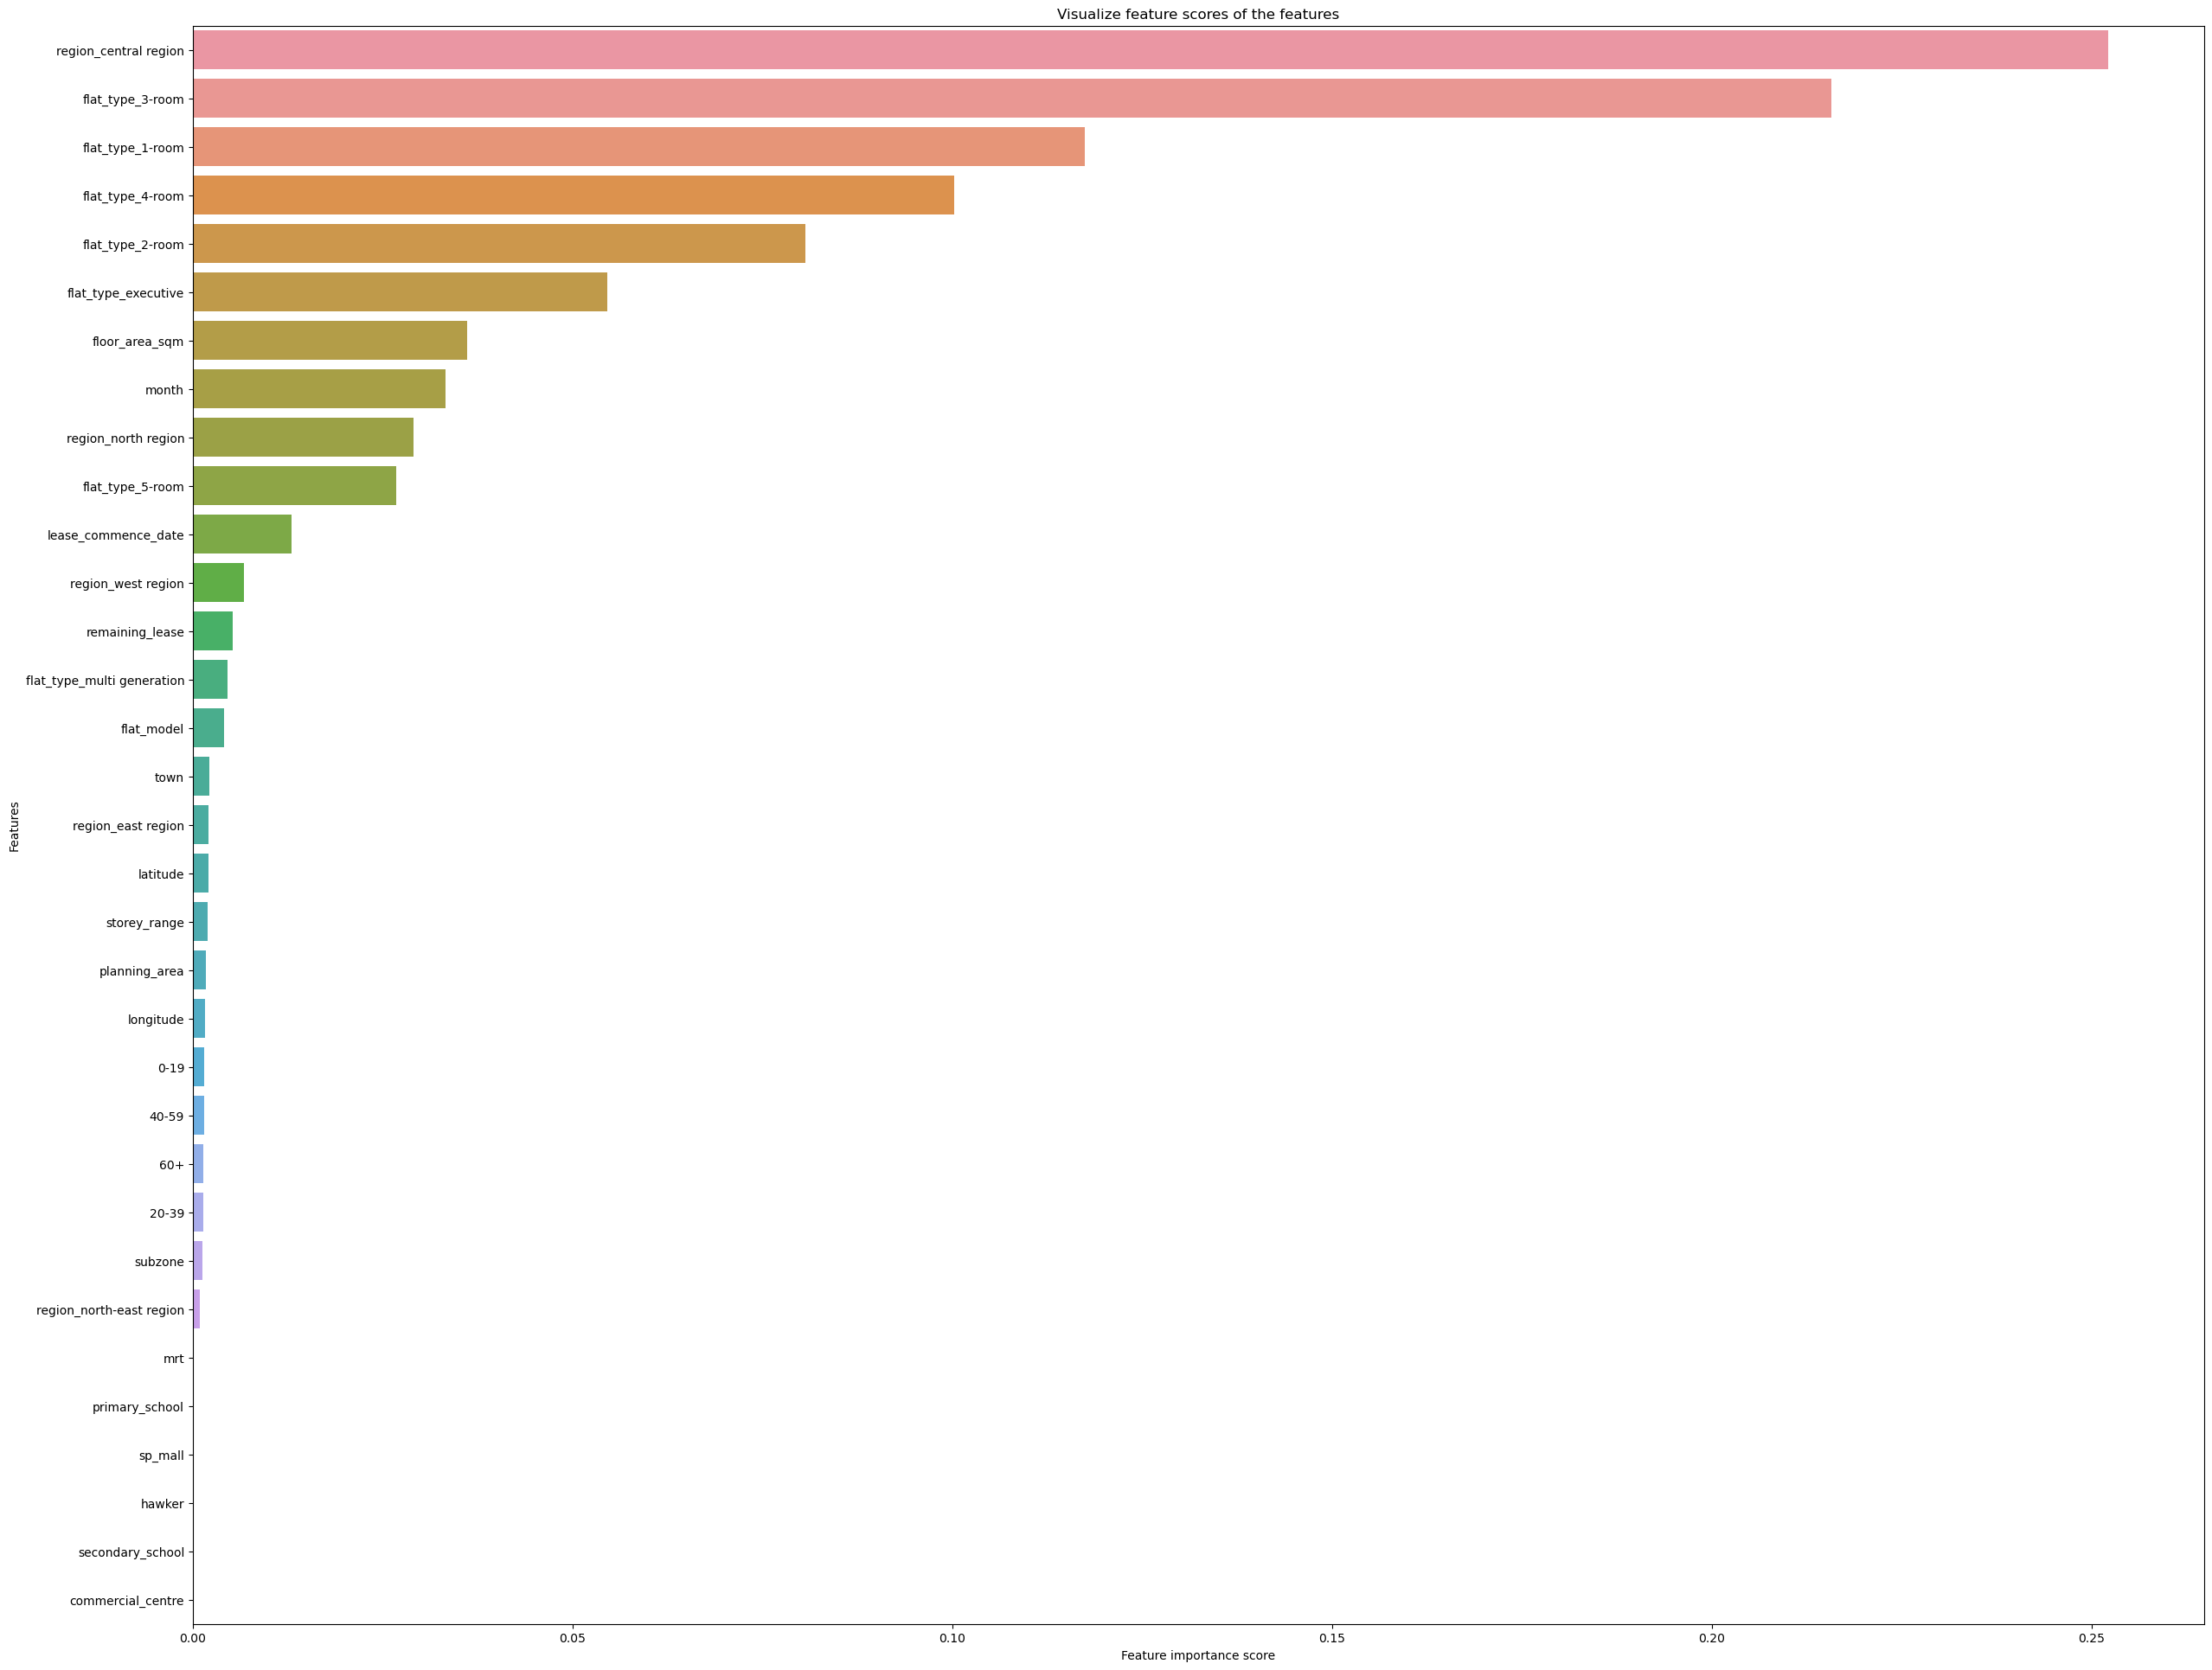

<Figure size 640x480 with 0 Axes>

In [164]:
feature_scores = pd.Series(stacked.feature_importances_, index=train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()
plt.savefig("Stacking-Features Importances")

In [ ]:
prediction = np.expm1(stacked.predict(test.values))

In [ ]:
data = {'Id': np.arange(prediction.shape[0]), 'Predicted': prediction.reshape(1, -1)[0]}
submission = pd.DataFrame(data=data)
submission


In [36]:
submission.to_csv('submission.csv', index=False)